# Zonal wind response: total response vs. cloud impact

This script generates figure 3: maps of total zonal wind response vs. cloud impact in ICON, MPI-ESM and IPSL-CM5A.

Note: for ICON, we investigate simulations with locked clouds and interactive water vapor. For MPI-ESM and IPSL-CM5A, we investigate simulations with both locked clouds and locked water vapor.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import helper_functions as fct

### Load own colorbar

In [2]:
mymap, mymap2 = fct.generate_mymap()

### Specify months and seasons of the year

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

### Specify simulations that are analyzed and impacts that are calculated

* xx_cld: locked clouds, interactive water vapor
* xx_cldvap: locked clouds, locked water vapor

In [4]:
runs_cld = ['T1C1', 'T2C2', 'T2C1', 'T1C2']
runs_cldvap = ['T1C1W1', 'T2C2W2', 'T1C2W1', 'T1C1W2',
               'T1C2W2', 'T2C1W1', 'T2C2W1', 'T2C1W2']

response_cld = ['total', 'SST', 'cloud']
response_cldvap = ['total', 'SST', 'cloud', 'water vapor']

### Read data (MPI-ESM, IPSL-CM5A with locked clouds and locked water vapor)

In [5]:
u850_mpi = {}; u850_ipsl = {}
for run in runs_cldvap:
    print('reading ' + run)
    # MPI-ESM
    #print('   MPI-ESM')
    ifile = 'MPI-ESM_' + run + '_3d_mm.uwind.nc'
    u850_mpi[run], lats_mpi, lons_mpi = fct.read_var_onelevel('../../MPI-ESM/' + ifile,
                                                              'u', 'plev', 850)
    del ifile
    
    # IPSL-CM5A
    #print('   IPSL-CM5A')
    ifile = 'IPSL-CM5A_' + run + '_3d_mm.remapcon.uwind.nc'
    u850_ipsl[run], lats_ipsl, lons_ipsl = fct.read_var_onelevel('../../IPSL-CM5A/' + ifile,
                                                                 'vitu', 'presnivs', 850)
    del ifile
del run

reading T1C1W1
reading T2C2W2
reading T1C2W1
reading T1C1W2
reading T1C2W2
reading T2C1W1
reading T2C2W1
reading T2C1W2


### Read data (ICON with locked clouds and interactive water vapor)

In [6]:
ipath = '../../ICON-NWP_lockedclouds/'
u850_icon = {}
for run in runs_cld:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    lats_icon = np.array(ncfile.variables['lat'][:].data)
    lons_icon = np.array(ncfile.variables['lon'][:].data)
    levs = np.array(ncfile.variables['lev'][:].data)
    uwind = np.array(ncfile.variables['u'][:].data)
    ncfile.close()    
    # get zonal wind at 850 hPa
    levind850 = (np.abs(levs-85000)).argmin() # index of 850 hPa level
    u850_icon[run] = uwind[:, levind850, :, :]
    del levs, uwind, levind850
    del ifile, ncfile
del run, ipath

reading T1C1
reading T2C2
reading T2C1
reading T1C2


### Calculate DJF mean

In [7]:
u850_mpi_djf = {}; u850_ipsl_djf = {}
for run in runs_cldvap:
    u850_mpi_djf[run] = fct.calcMonthlyandSeasonMean(u850_mpi[run],
                                                     months, seasons)[1]['DJF']
    u850_ipsl_djf[run] = fct.calcMonthlyandSeasonMean(u850_ipsl[run],
                                                      months, seasons)[1]['DJF']
del run

u850_icon_djf = {}
for run in runs_cld:
    u850_icon_djf[run] = fct.calcMonthlyandSeasonMean(u850_icon[run],
                                                      months,
                                                      seasons)[1]['DJF']
del run

del u850_mpi, u850_ipsl, u850_icon

### Calculate DJF responses and decompose the total response into contributions from changes in SST, clouds and water vapor

In [8]:
du850_mpi = np.full((len(response_cldvap), len(lats_mpi),
                     len(lons_mpi)), np.nan, dtype=float)
du850_ipsl = np.full((len(response_cldvap), len(lats_ipsl),
                     len(lons_ipsl)), np.nan, dtype=float)

du850_mpi[0, :, :], du850_mpi[1, :, :], du850_mpi[2, :, :], \
du850_mpi[3, :, :] = \
  fct.calc_3impacts_timmean(u850_mpi_djf['T1C1W1'], u850_mpi_djf['T2C2W2'],
                            u850_mpi_djf['T1C2W2'], u850_mpi_djf['T2C1W1'],
                            u850_mpi_djf['T1C2W1'], u850_mpi_djf['T1C1W2'],
                            u850_mpi_djf['T2C2W1'], u850_mpi_djf['T2C1W2'])
du850_ipsl[0, :, :], du850_ipsl[1, :, :], du850_ipsl[2, :, :], \
du850_ipsl[3, :, :] = \
  fct.calc_3impacts_timmean(u850_ipsl_djf['T1C1W1'], u850_ipsl_djf['T2C2W2'],
                            u850_ipsl_djf['T1C2W2'], u850_ipsl_djf['T2C1W1'],
                            u850_ipsl_djf['T1C2W1'], u850_ipsl_djf['T1C1W2'],
                            u850_ipsl_djf['T2C2W1'], u850_ipsl_djf['T2C1W2'])

du850_icon = np.full((len(response_cld), len(lats_icon),
                      len(lons_icon)), np.nan, dtype=float)
du850_icon[0, :, :], du850_icon[1, :, :], du850_icon[2, :, :] = \
  fct.calc_impacts_timmean(u850_icon_djf['T1C1'], u850_icon_djf['T2C2'],
                           u850_icon_djf['T1C2'], u850_icon_djf['T2C1'])


### Read masks for significant responses

These masks are generated with the script "calculate_significance_bootstrapping.ipynb" based on time series of the seasonal-mean zonal wind.

The seasonal-mean zonal wind is calculated with cdo (Climate Data Operators):

* select zonal wind: cdo selvar,u ICON-NWP_AMIP_run_3d_mm.nc ICON-NWP_AMIP_run_3d_mm.uwind.nc
* calculate the seasonal mean: cdo seasmean ICON-NWP_AMIP_run_3d_mm.uwind.nc ICON-NWP_AMIP_run_3d_mm.uwind.seasmean.nc

"run" can be any of the simulations

In [9]:
# ICON
ipath = '../../ICON-NWP_lockedclouds/'
mask_read = np.load(ipath + 'du850_mask_sm_bs.npy',
                    allow_pickle='TRUE').item()
du850_mask_icon = np.array([mask_read[r][seasons.index('DJF'), :, :] \
                            for r in response_cld])
del mask_read, ipath

##############################################################################
# MPI-ESM
mask_read = np.load('../../MPI-ESM/MPI-ESM_du850_mask_sm_bs.npy',
                    allow_pickle='TRUE').item()
du850_mask_mpi = np.array([mask_read[r][seasons.index('DJF'), :, :] \
                           for r in response_cldvap])
# shift latitudes to go from South to North and not from North to South
du850_mask_mpi = du850_mask_mpi[:, ::-1, :]
del mask_read

##############################################################################
# IPSL-CM5A
mask_read = np.load('../../IPSL-CM5A/IPSL-CM5A_du850_mask_sm_bs.npy',
                    allow_pickle='TRUE').item()
du850_mask_ipsl = np.array([mask_read[r][seasons.index('DJF'), :, :] \
                            for r in response_cldvap])
del mask_read

### Calculate jet latitude in the control simulations for the Northern Hemisphere

In [10]:
# latitudes in Northern Hemisphere
latind0 = (np.abs(lats_icon-0)).argmin() + 1
lats_NH = lats_icon[latind0:]

# shift longitudes from 0deg...360deg to -270deg...90deg for visualization reasons
# and look at NH
u850_icon_shift, lons_shift = fct.shiftgrid_copy(90.,
                                                 u850_icon_djf['T1C1'][latind0:, :],
                                                 lons_icon, start=False)
u850_mpi_shift, _ = fct.shiftgrid_copy(90.,
                                       u850_mpi_djf['T1C1W1'][latind0:, :],
                                       lons_mpi, start=False)
u850_ipsl_shift, _ = fct.shiftgrid_copy(90.,
                                        u850_ipsl_djf['T1C1W1'][latind0:, :],
                                        lons_ipsl, start=False)

jetlat_icon_nh = np.full(lons_shift.size, np.nan, dtype=float)
jetlat_mpi_nh = np.full(lons_shift.size, np.nan, dtype=float)
jetlat_ipsl_nh = np.full(lons_shift.size, np.nan, dtype=float)
for lo in range(lons_shift.size):
    # ICON
    jetlat_icon_nh[lo], _ = \
       fct.get_eddyjetlatint_NH(u850_icon_shift[:, lo], lats_NH)
    # MPI-ESM
    jetlat_mpi_nh[lo], _ = \
       fct.get_eddyjetlatint_NH(u850_mpi_shift[:, lo], lats_NH)
    # IPSL-CM5A
    jetlat_ipsl_nh[lo], _ = \
       fct.get_eddyjetlatint_NH_nan(u850_ipsl_shift[:, lo],
                                    lats_NH, lons_shift[lo])
del lo

del u850_icon_shift, u850_mpi_shift, u850_ipsl_shift, lons_shift

### Prepare plot of total response and cloud impact

Shift the longitudes from 0deg...360deg to -90deg...270deg for visualization reasons and select the North Atlantic region (otherwise it is very slow to add the dots for the regions, in which the response is significant).

In [11]:
# shift longitudes
lons_plot = fct.shiftgrid_copy(90., du850_icon, lons_icon, start=False)[1]

# North Atlantic region
lonind_west = (np.abs(lons_plot--90)).argmin() # find index of 90°W
lonind_east = (np.abs(lons_plot-35)).argmin() # find index of 35°E
latind_sout = (np.abs(lats_icon-20)).argmin() # find index of 20°N
latind_nort = (np.abs(lats_icon-80)).argmin() # find index of 80°N

lons_plot = lons_plot[lonind_west:lonind_east+1]
lats_plot = lats_icon[latind_sout:latind_nort+1]

# MPI-ESM uses slightly different latitudes
latind_sout_mpi = (np.abs(lats_mpi-20)).argmin() # find index of 20°N
latind_nort_mpi = (np.abs(lats_mpi-80)).argmin() # find index of 80°N
lats_mpi_plot = lats_mpi[latind_sout_mpi:latind_nort_mpi+1]

# shift zonal wind fields and masks
du850_icon_plot = fct.shiftgrid_copy(90., du850_icon, lons_icon,
                                     start=False)[0][:,
                                                     latind_sout:latind_nort+1,
                                                     lonind_west:lonind_east+1]
mask_icon_plot = fct.shiftgrid_copy(90., du850_mask_icon, lons_icon,
                                    start=False)[0][:,
                                                    latind_sout:latind_nort+1,
                                                    lonind_west:lonind_east+1]

du850_mpi_plot = fct.shiftgrid_copy(90., du850_mpi, lons_mpi,
                                    start=False)[0][:,
                                                    latind_sout_mpi:latind_nort_mpi+1,
                                                    lonind_west:lonind_east+1]
mask_mpi_plot = fct.shiftgrid_copy(90., du850_mask_mpi, lons_mpi,
                                   start=False)[0][:,
                                                   latind_sout_mpi:latind_nort_mpi+1,
                                                   lonind_west:lonind_east+1]

du850_ipsl_plot = fct.shiftgrid_copy(90., du850_ipsl, lons_ipsl,
                                     start=False)[0][:,
                                                     latind_sout:latind_nort+1,
                                                     lonind_west:lonind_east+1]
mask_ipsl_plot = fct.shiftgrid_copy(90., du850_mask_ipsl, lons_ipsl,
                                    start=False)[0][:,
                                                    latind_sout:latind_nort+1,
                                                    lonind_west:lonind_east+1]

### Plot the total response and cloud impact on u850

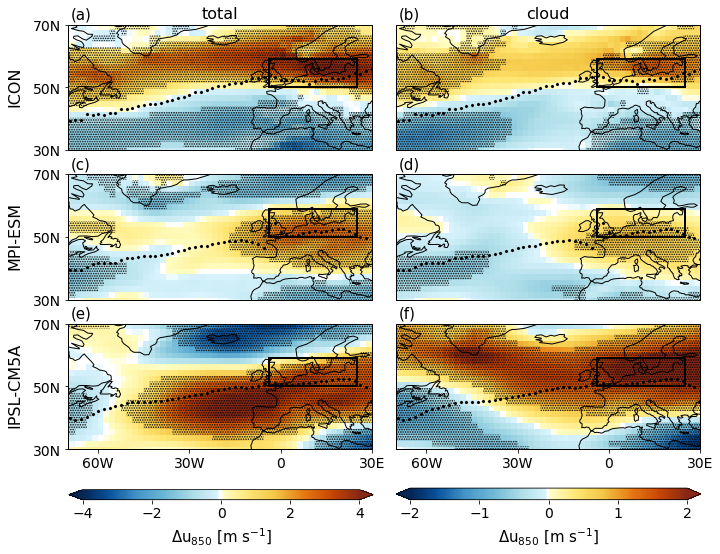

In [12]:
mods = ['ICON', 'MPI-ESM', 'IPSL-CM5A']
vlim_tot = 4
vlim_cld = 2
# boundaries of region with robust response
lonwest = -4; loneast = 25; latsout = 50; latnort = 59

proj = ccrs.PlateCarree(central_longitude=-90)
fig, ax = plt.subplots(3, 2, figsize=(10,7),
                       subplot_kw=dict(projection=proj))
for i in range(ax.shape[0]):
    for k in range(ax.shape[1]):
        ax[i, k].coastlines(rasterized=True)
        ax[i, k].set_aspect('auto')
        ax[i, k].tick_params(labelsize=14)
        # extended North Atlantic region
        ax[i, k].set_extent([-70, 30, 30, 70], ccrs.PlateCarree())
        # set xticks and yticks for latitudes and longitudes
        # xaxis: longitudes
        if i == 2: # last row
            ax[i, k].set_xticks([-60, -30, 0, 30], crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                                degree_symbol='',
                                                dateline_direction_label=True)
            ax[i, k].xaxis.set_major_formatter(lon_formatter)
            del lon_formatter
        # yaxis: latitudes
        if k == 0: # first column
            ax[i, k].set_yticks([30, 50, 70], crs=ccrs.PlateCarree())
            lat_formatter = LatitudeFormatter(degree_symbol='')
            ax[i, k].yaxis.set_major_formatter(lat_formatter)
            del lat_formatter
        # draw box around region, for which we determine the area-mean response
        # left vertical line
        ax[i, k].plot([lonwest, lonwest], [latsout, latnort],
                      linewidth=2, color='k', transform=ccrs.PlateCarree())
        # right vertical line
        ax[i, k].plot([loneast, loneast], [latsout, latnort],
                      linewidth=2, color='k', transform=ccrs.PlateCarree())
        # upper horizontal line
        ax[i, k].plot([loneast, lonwest], [latnort, latnort],
                      linewidth=2, color='k', transform=ccrs.PlateCarree())
        # lower horizontal line
        ax[i, k].plot([lonwest, loneast], [latsout, latsout],
                      linewidth=2, color='k', transform=ccrs.PlateCarree())
    del k
del i
del lonwest, loneast, latsout, latnort
# total response
# ICON
k = response_cldvap.index('total') # 0
cf = ax[0, 0].pcolormesh(lons_plot, lats_plot,
                         du850_icon_plot[k, :, :],
                         vmin=-vlim_tot, vmax=vlim_tot, cmap=mymap2,
                         rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[0, 0].pcolor(lons_plot, lats_plot,
                np.ma.masked_values(1*mask_icon_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
# MPI-ESM
ax[1, 0].pcolormesh(lons_plot, lats_mpi_plot,
                    du850_mpi_plot[k, :, :],
                    vmin=-vlim_tot, vmax=vlim_tot, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[1, 0].pcolor(lons_plot, lats_mpi_plot,
                np.ma.masked_values(1*mask_mpi_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
# IPSL-CM5A
ax[2, 0].pcolormesh(lons_plot, lats_plot,
                    du850_ipsl_plot[k, :, :],
                    vmin=-vlim_tot, vmax=vlim_tot, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[2, 0].pcolor(lons_plot, lats_plot,
                np.ma.masked_values(1*mask_ipsl_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
del k
##################################################
# cloud impact
k = response_cldvap.index('cloud') # 2
# ICON
cf1 = ax[0, 1].pcolormesh(lons_plot, lats_plot,
                          du850_icon_plot[k, :, :],
                          vmin=-vlim_cld, vmax=vlim_cld, cmap=mymap2,
                          rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[0, 1].pcolor(lons_plot, lats_plot,
                np.ma.masked_values(1*mask_icon_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
# MPI-ESM
ax[1, 1].pcolormesh(lons_plot, lats_mpi_plot,
                    du850_mpi_plot[k, :, :],
                    vmin=-vlim_cld, vmax=vlim_cld, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[1, 1].pcolor(lons_plot, lats_mpi_plot,
                np.ma.masked_values(1*mask_mpi_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
# IPSL-CM5A
ax[2, 1].pcolormesh(lons_plot, lats_plot,
                    du850_ipsl_plot[k, :, :],
                    vmin=-vlim_cld, vmax=vlim_cld, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# stippling for significant response
ax[2, 1].pcolor(lons_plot, lats_plot,
                np.ma.masked_values(1*mask_ipsl_plot[k, :, :], 0),
                hatch='.....', alpha=0., rasterized=True,
                transform=ccrs.PlateCarree())
del k
##################################################
# jet latitude in control simulation
for k in range(ax.shape[1]):
    ax[0, k].plot(lons_plot, jetlat_icon_nh[lonind_west:lonind_east+1],
                  marker='x', color='k', linestyle='none', markeredgewidth=2,
                  markersize=2, transform=ccrs.PlateCarree())
    ax[1, k].plot(lons_plot, jetlat_mpi_nh[lonind_west:lonind_east+1],
                  marker='x', color='k', linestyle='none', markeredgewidth=2,
                  markersize=2, transform=ccrs.PlateCarree())
    ax[2, k].plot(lons_plot, jetlat_ipsl_nh[lonind_west:lonind_east+1],
                  marker='x', color='k', linestyle='none', markeredgewidth=2,
                  markersize=2, transform=ccrs.PlateCarree())

# titles
ax[0, 0].set_title('total', fontsize=16)
ax[0, 1].set_title('cloud', fontsize=16)

# labels for models
for i in range(ax.shape[0]):
    ax[i, 0].text(-0.15, 0.51, mods[i], va='bottom', ha='center',
                  rotation='vertical', rotation_mode='anchor',
                  fontsize=16, transform=ax[i, 0].transAxes)
del i

fig.canvas.draw()
fig.tight_layout()

# a), b) etc for subplots
labs = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
ax = ax.reshape(-1)
for i in range(ax.shape[0]):
    ax[i].text(0.01, 1.02, labs[i], va='bottom', ha='left',
               rotation_mode='anchor', fontsize=15,
               transform=ax[i].transAxes)
del i

# colorbar for response
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.09, 0.0, 0.423, 0.02]) # left,bottom,width,height
cb = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label('$\Delta$u$_{850}$ [m s$^{-1}$]', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf

cbar_ax = fig.add_axes([0.545, 0.0, 0.423, 0.023]) # left,bottom,width,height
cb = fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label('$\Delta$u$_{850}$ [m s$^{-1}$]', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf1

fig.savefig('figure3a_3f.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax, proj

del mods, vlim_tot, vlim_cld